In [3]:
import emcee
import numpy as np
import scipy
from astropy.io import fits
from astropy.table import Table
from astropy.io import fits
import matplotlib.pyplot as plt
from astropy.table import Table
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.cosmology import Planck18 as cosmo
from functools import partial
import time

In [4]:
path_halo = '/sps/lsst/groups/clusters/cluster_comparison_project/after_matching/cosmoDC2_pywazp.DC2.tpz.T500k.pointEstimateMags/zband/member_matching/fshare_0.1_pref_more_massive/cat1.fits'

path_amas = '/sps/lsst/groups/clusters/cluster_comparison_project/after_matching/cosmoDC2_pywazp.DC2.tpz.T500k.pointEstimateMags/zband/member_matching/fshare_0.1_pref_more_massive/cat2.fits'

t = Table.read(path_amas)

def table(path):
    with fits.open(path) as hdul:
        table = Table(hdul[1].data)
    return table

t_halo = table(path_halo)
t_amas = table(path_amas)
t_amas_match = t_amas[t_amas["mt_cross"] !='']

M = []
for id in t_amas_match["mt_cross"]:
    ligne = t_halo[t_halo["halo_id"] == id]
    M.append(ligne["m200c"][0])
t_amas_match["M"] = M
t_amas_match = t_amas_match[t_amas_match["snr"]>6]

def tableau_coupure_n200(coupure):
    return t_amas_match[t_amas_match["n200"]>coupure]

Mp, zp = 10**14.3, 0.5
list_coupures = np.linspace(20, 80, 13)
print("liste des coupures :", list_coupures)

liste des coupures : [20. 25. 30. 35. 40. 45. 50. 55. 60. 65. 70. 75. 80.]


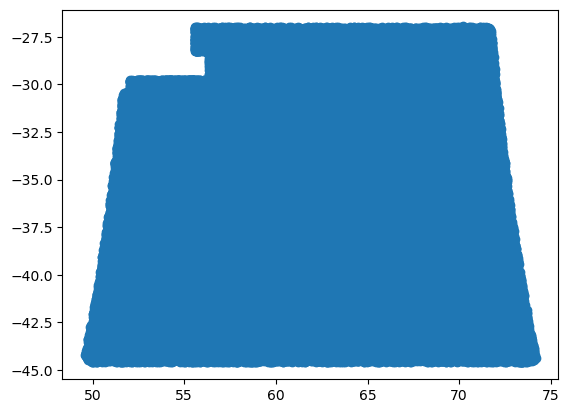

In [22]:
plt.scatter(t["ra"], t["dec"])


In [218]:
def prior(params):
    A, B, C, D, E, F = params
    if -2<C<2 or -2<E<2 or -2<F<2:
        return True
    else:
        return False

#X est le catalogue
def _ln_L(params, X, a, b):
    A, B, C, D, E, F = params
    prior_check = prior(params)
    if not prior_check:
        return -np.inf
    pop, M, z = np.log(X["n200"]), X["M"], X["zp"]
    mean_alpha = A + B*np.log(M/Mp) + C*np.log((1+z)/(1+zp))
    sigma = D + E*np.log(M/Mp) + F*np.log((1+z)/(1+zp))
    sigma = np.clip(sigma, 1e-5, None)
    #print("sigma max/min :", max(sigma), min(sigma))
    #log-Vraissemblance
    erf = lambda x: scipy.special.erf((np.log(x)-mean_alpha)/(sigma*2**0.5))
    correction = lambda a, b: erf(b)-erf(a)
    ln_L = - sum(np.log(sigma*(2*np.pi)**0.5)) - sum(0.5*((pop-mean_alpha)/sigma)**2) - sum(0.5*correction(a, b))
    return ln_L

In [219]:
a = min(t_amas_match["n200"])
b = max(t_amas_match["n200"])
print(a, b)
print(np.log(a), np.log(b))
erf = lambda x: scipy.special.erf((np.log(x)-1)/(2*1**2))
print(erf(a), erf(b))

5.042 303.573
1.6178029 5.715622
0.33778176 0.9991453


In [220]:
ndim, nwalkers = 6, 25
ivar = 1. / np.random.rand(ndim)
p0 = np.random.randn(nwalkers, ndim) # points de départ pour les walkers

sampler = emcee.EnsembleSampler(nwalkers, ndim, _ln_L, args=[t_amas_match, a, b])

In [234]:
S = sampler.run_mcmc(p0, 5000)

In [235]:
sampler.get_chain().shape

(5500, 25, 6)

In [236]:
sample = sampler.get_chain()
sample[-1, 0]

array([ 3.33689363,  0.38980439,  0.62628656,  0.51423181,  0.05437978,
       -0.08479164])

In [237]:
list_mean_A, list_mean_B, list_mean_C, list_mean_D, list_mean_E, list_mean_F  = [], [], [], [], [], []
list_A, list_B, list_C, list_D, list_E, list_F  = [], [], [], [], [], []

In [238]:
for step in range(len(sample)):
    list_mean_A.append(np.mean(sample[step, :, 0])) # récupération des paramètres
    list_mean_B.append(np.mean(sample[step, :, 1]))
    list_mean_C.append(np.mean(sample[step, :, 2]))
    list_mean_D.append(np.mean(sample[step, :, 3]))
    list_mean_E.append(np.mean(sample[step, :, 4]))
    list_mean_F.append(np.mean(sample[step, :, 5]))
    for walker in range(len(sample[step])):
        list_A.append(sample[step, walker, 0])
        list_B.append(sample[step, walker, 1])
        list_C.append(sample[step, walker, 2])
        list_D.append(sample[step, walker, 3])
        list_E.append(sample[step, walker, 4])
        list_F.append(sample[step, walker, 5])

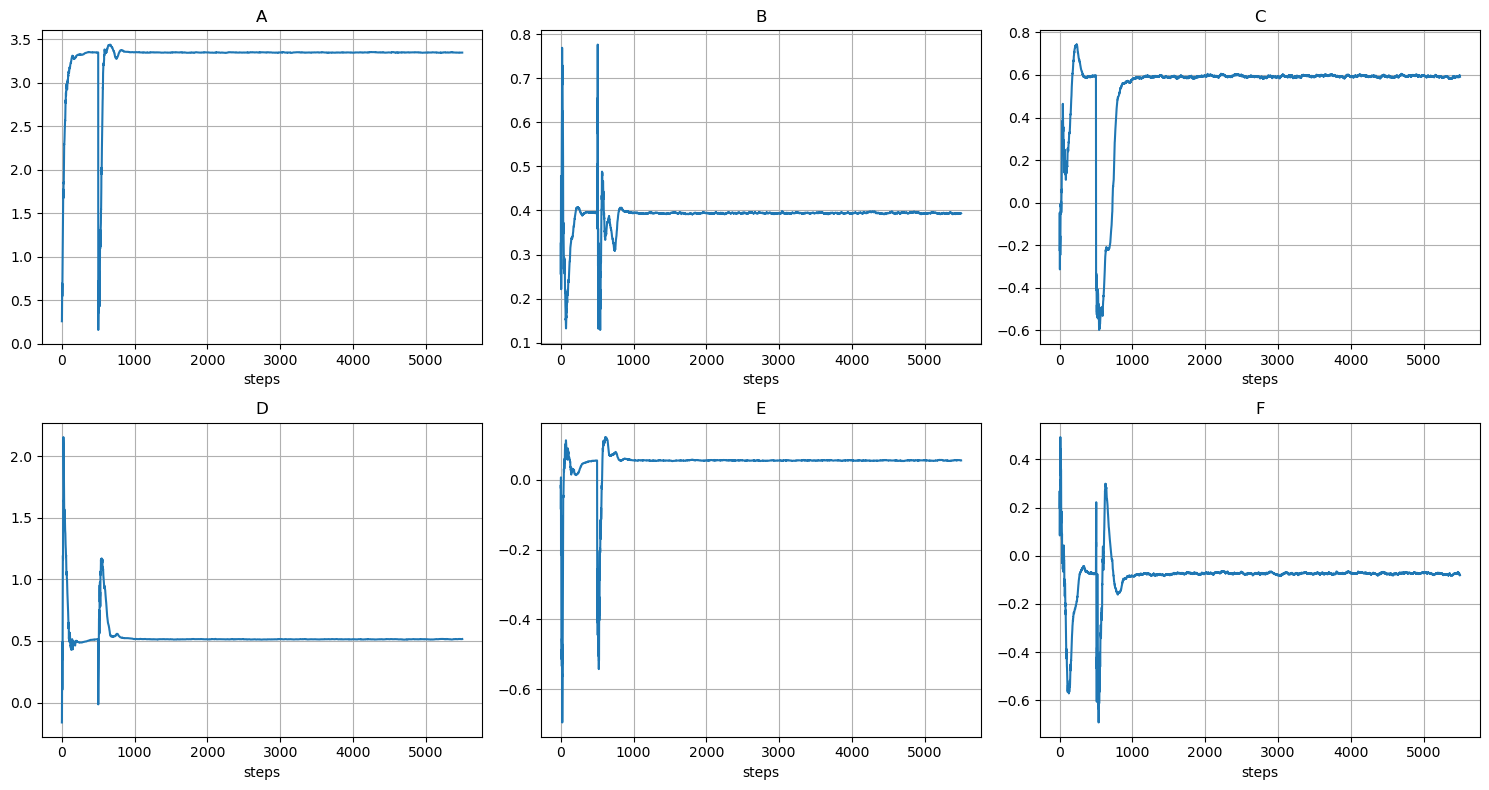

In [239]:
steps = np.arange(0, len(list_mean_A), 1)
fig, axes = plt.subplots(2, 3, figsize=(15, 8), sharex=False, sharey=False)
A = axes[0, 0]
B = axes[0, 1]
C = axes[0, 2]
D = axes[1, 0]
E = axes[1, 1]
F = axes[1, 2]

A.plot(steps, list_mean_A)
A.set_title('A')
A.set_xlabel('steps')
#A.set_yscale('log')
A.grid(True)

B.plot(steps, list_mean_B)
B.set_title('B')
B.set_xlabel('steps')
#B.set_yscale('log')
B.grid(True)

C.plot(steps, list_mean_C)
C.set_title('C')
C.set_xlabel('steps')
#C.set_yscale('log')
C.grid(True)

D.plot(steps, list_mean_D)
D.set_title('D')
D.set_xlabel('steps')
#D.set_yscale('log')
D.grid(True)

E.plot(steps, list_mean_E)
E.set_title('E')
E.set_xlabel('steps')
#E.set_yscale('log')
E.grid(True)

F.plot(steps, list_mean_F)
F.set_title('F')
F.set_xlabel('steps')
#F.set_yscale('log')
F.grid(True)

plt.tight_layout()
plt.show()


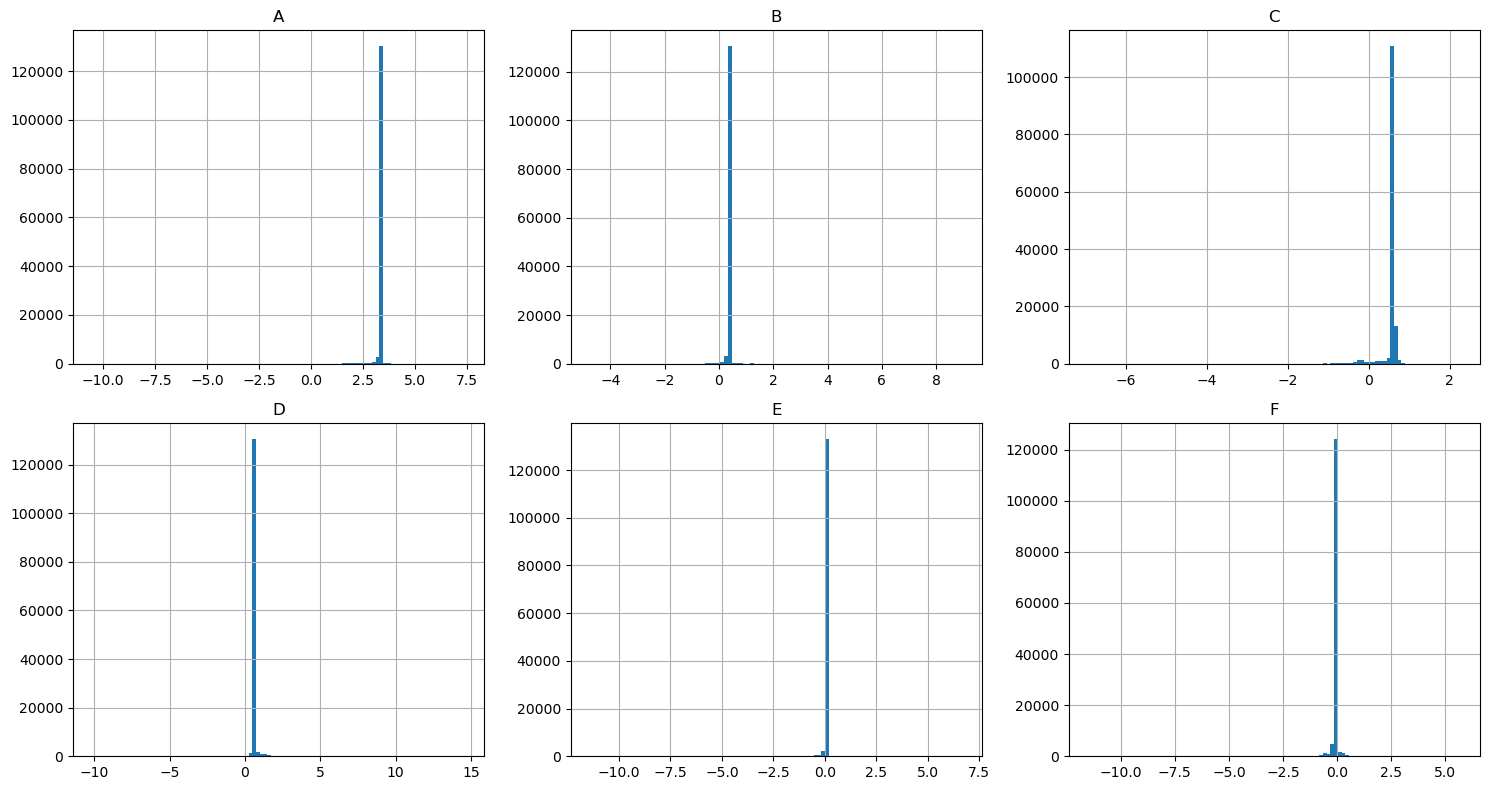

In [240]:
fig, axes = plt.subplots(2, 3, figsize=(15, 8), sharex=False, sharey=False)
bins = 100
A = axes[0, 0]
B = axes[0, 1]
C = axes[0, 2]
D = axes[1, 0]
E = axes[1, 1]
F = axes[1, 2]

A.hist(list_A, bins = bins)
A.set_title('A')
#A.set_xlabel('steps')
#A.set_yscale('log')
A.grid(True)

B.hist(list_B, bins = bins)
B.set_title('B')
#B.set_xlabel('steps')
#B.set_yscale('log')
B.grid(True)

C.hist(list_C, bins = bins)
C.set_title('C')
#C.set_xlabel('steps')
#C.set_yscale('log')
C.grid(True)

D.hist(list_D, bins = bins)
D.set_title('D')
#D.set_xlabel('steps')
#D.set_yscale('log')
D.grid(True)

E.hist(list_E, bins = bins)
E.set_title('E')
#E.set_xlabel('steps')
#E.set_yscale('log')
E.grid(True)

F.hist(list_F, bins = bins)
F.set_title('F')
#F.set_xlabel('steps')
#F.set_yscale('log')
F.grid(True)

plt.tight_layout()
plt.show()


In [241]:
A = np.mean(np.array(list_A)[len(list_A)//2:])
B = np.mean(np.array(list_B)[len(list_B)//2:])
C = np.mean(np.array(list_C)[len(list_C)//2:])
D = np.mean(np.array(list_D)[len(list_D)//2:])
E = np.mean(np.array(list_E)[len(list_E)//2:])
F = np.mean(np.array(list_F)[len(list_F)//2:])

std_A = np.std(np.array(list_A)[len(list_A)//2:])
std_B = np.std(np.array(list_B)[len(list_B)//2:])
std_C = np.std(np.array(list_C)[len(list_C)//2:])
std_D = np.std(np.array(list_D)[len(list_D)//2:])
std_E = np.std(np.array(list_E)[len(list_E)//2:])
std_F = np.std(np.array(list_F)[len(list_F)//2:])

In [242]:
print('A =', round(A, 5), "+-", round(std_A, 5))
print('B =', round(B, 5), "+-", round(std_B, 5))
print('C =', round(C, 5), "+-", round(std_C, 5))
print('D =', round(D, 5), "+-", round(std_D, 5))
print('E =', round(E, 5), "+-", round(std_E, 5))
print('F =', round(F, 5), "+-", round(std_F, 5))

A = 3.34957 +- 0.00863
B = 0.394 +- 0.00559
C = 0.59342 +- 0.02127
D = 0.51366 +- 0.00521
E = 0.05574 +- 0.00316
F = -0.07401 +- 0.01581


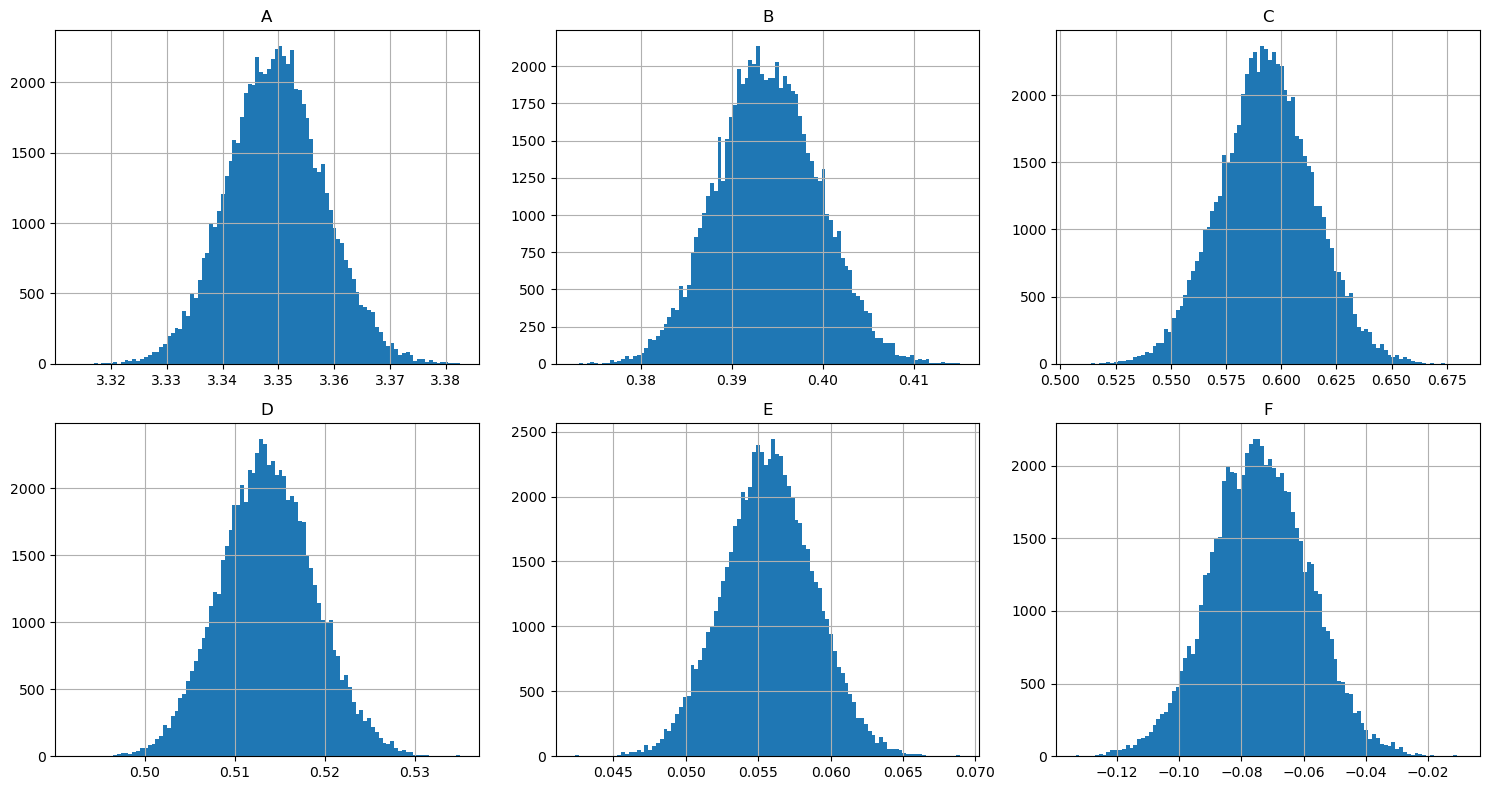

In [243]:
fig, axes = plt.subplots(2, 3, figsize=(15, 8), sharex=False, sharey=False)
bins = 100
A = axes[0, 0]
B = axes[0, 1]
C = axes[0, 2]
D = axes[1, 0]
E = axes[1, 1]
F = axes[1, 2]

A.hist(np.array(list_A)[len(list_A)//2:], bins = bins)
A.set_title('A')
#A.set_xlabel('steps')
#A.set_yscale('log')
A.grid(True)

B.hist(np.array(list_B)[len(list_B)//2:], bins = bins)
B.set_title('B')
#B.set_xlabel('steps')
#B.set_yscale('log')
B.grid(True)

C.hist(np.array(list_C)[len(list_C)//2:], bins = bins)
C.set_title('C')
#C.set_xlabel('steps')
#C.set_yscale('log')
C.grid(True)

D.hist(np.array(list_D)[len(list_D)//2:], bins = bins)
D.set_title('D')
#D.set_xlabel('steps')
#D.set_yscale('log')
D.grid(True)

E.hist(np.array(list_E)[len(list_E)//2:], bins = bins)
E.set_title('E')
#E.set_xlabel('steps')
#E.set_yscale('log')
E.grid(True)

F.hist(np.array(list_F)[len(list_F)//2:], bins = bins)
F.set_title('F')
#F.set_xlabel('steps')
#F.set_yscale('log')
F.grid(True)

plt.tight_layout()
plt.show()


In [244]:
list_A_cut = np.array(list_A)[len(list_A)//2:]
list_B_cut = np.array(list_B)[len(list_B)//2:]
list_C_cut = np.array(list_C)[len(list_C)//2:]
list_D_cut = np.array(list_D)[len(list_D)//2:]
list_E_cut = np.array(list_E)[len(list_E)//2:]
list_F_cut = np.array(list_F)[len(list_F)//2:]

Removed no burn in


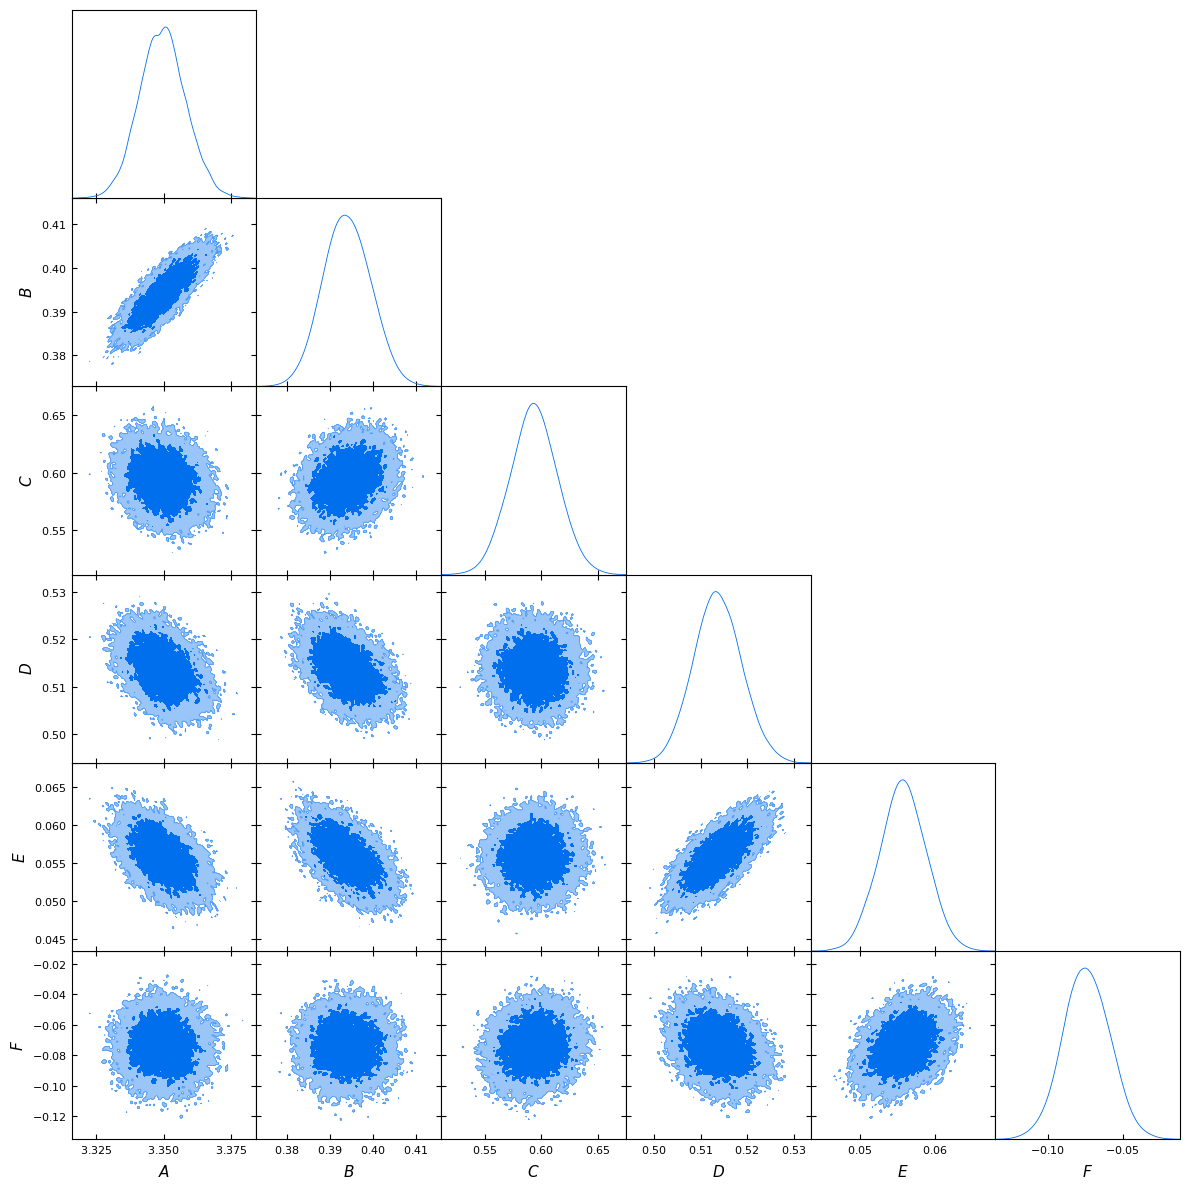

In [245]:
from getdist import plots, MCSamples
import numpy as np

# Assuming list_A_cut, list_B_cut, etc., are numpy arrays with shape (num_params, num_samples)
# and you only want to combine A and B for now:

# Transpose so that each row is a sample
list_A_cut
list_B_cut

# Combine samples from A and B
all_samples = np.vstack([list_A_cut, list_B_cut, list_C_cut, list_D_cut, list_E_cut, list_F_cut])  # shape: (n_samples_total, n_params)

# Define parameter names and labels
names = ["A", "B", "C", "D", "E", "F"]  # Replace with your actual parameter names

# Create MCSamples object
samples = MCSamples(samples=all_samples.T, names=names, labels=names)

# Plot
g = plots.get_subplot_plotter()
g.triangle_plot([samples], filled=True)
g.export('output_file.pdf')

In [176]:
from getdist import plots, MCSamples
import getdist
import matplotlib.pyplot as plt
import IPython

In [177]:
ndim = 4
nsamp = 10000
random_state = np.random.default_rng(10) # seed random generator
A = random_state.random((ndim,ndim))
cov = np.dot(A, A.T)
samps = random_state.multivariate_normal([0]*ndim, cov, size=nsamp)
A = random_state.random((ndim,ndim))
cov = np.dot(A, A.T)
samps2 = random_state.multivariate_normal([0]*ndim, cov, size=nsamp)

In [178]:
names = ["x%s"%i for i in range(ndim)]
labels =  ["x_%s"%i for i in range(ndim)]
samples = MCSamples(samples=samps,names = names, labels = labels)
samples2 = MCSamples(samples=samps2,names = names, labels = labels, label='Second set')

Removed no burn in
Removed no burn in


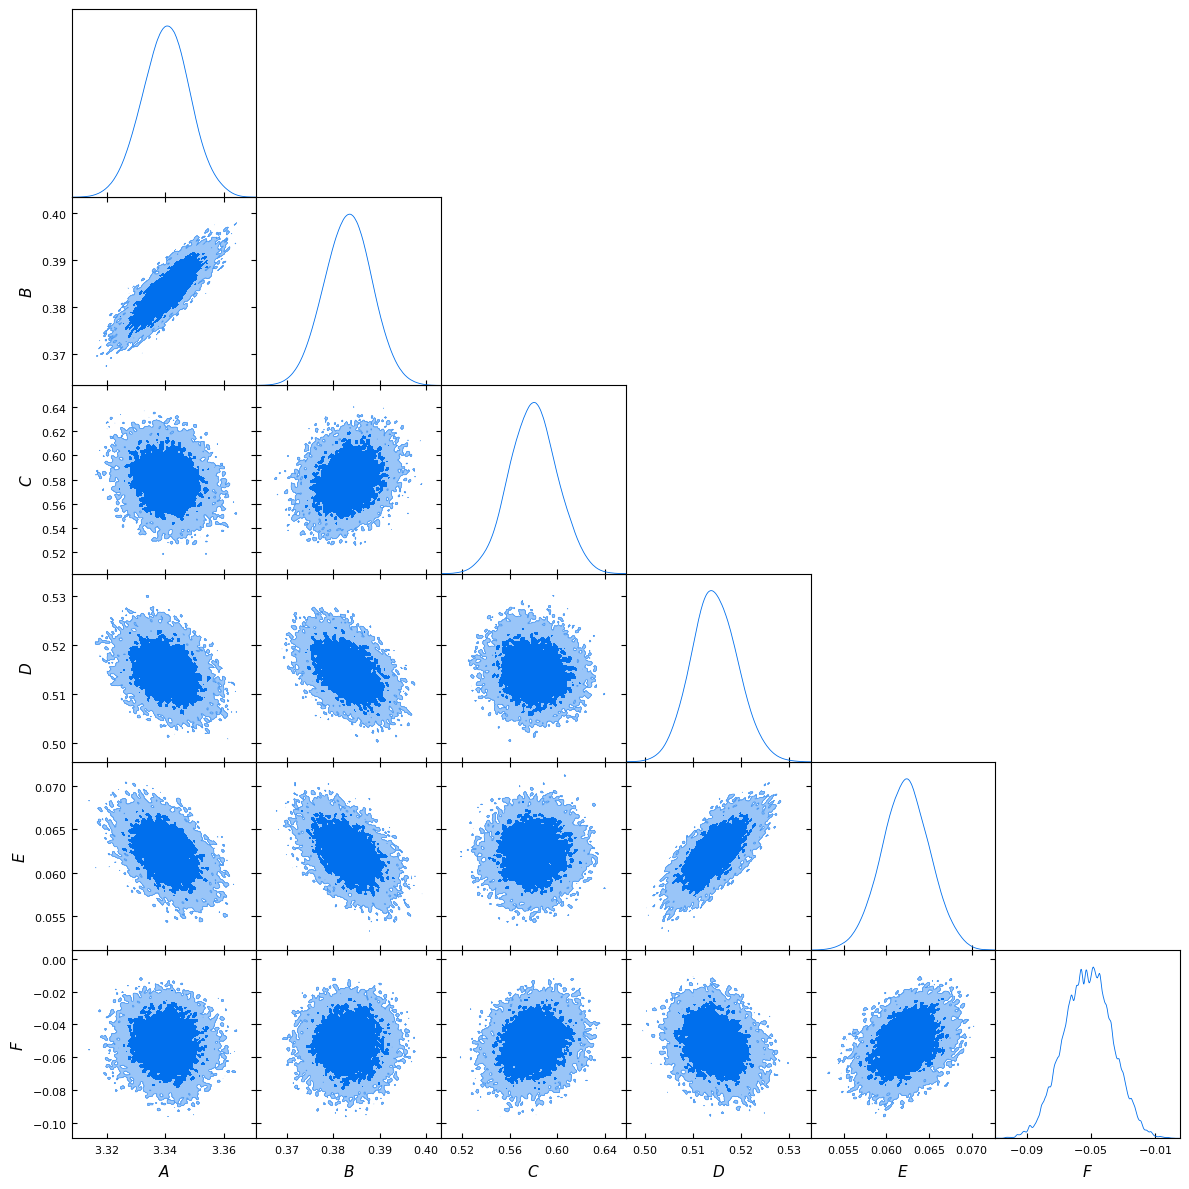

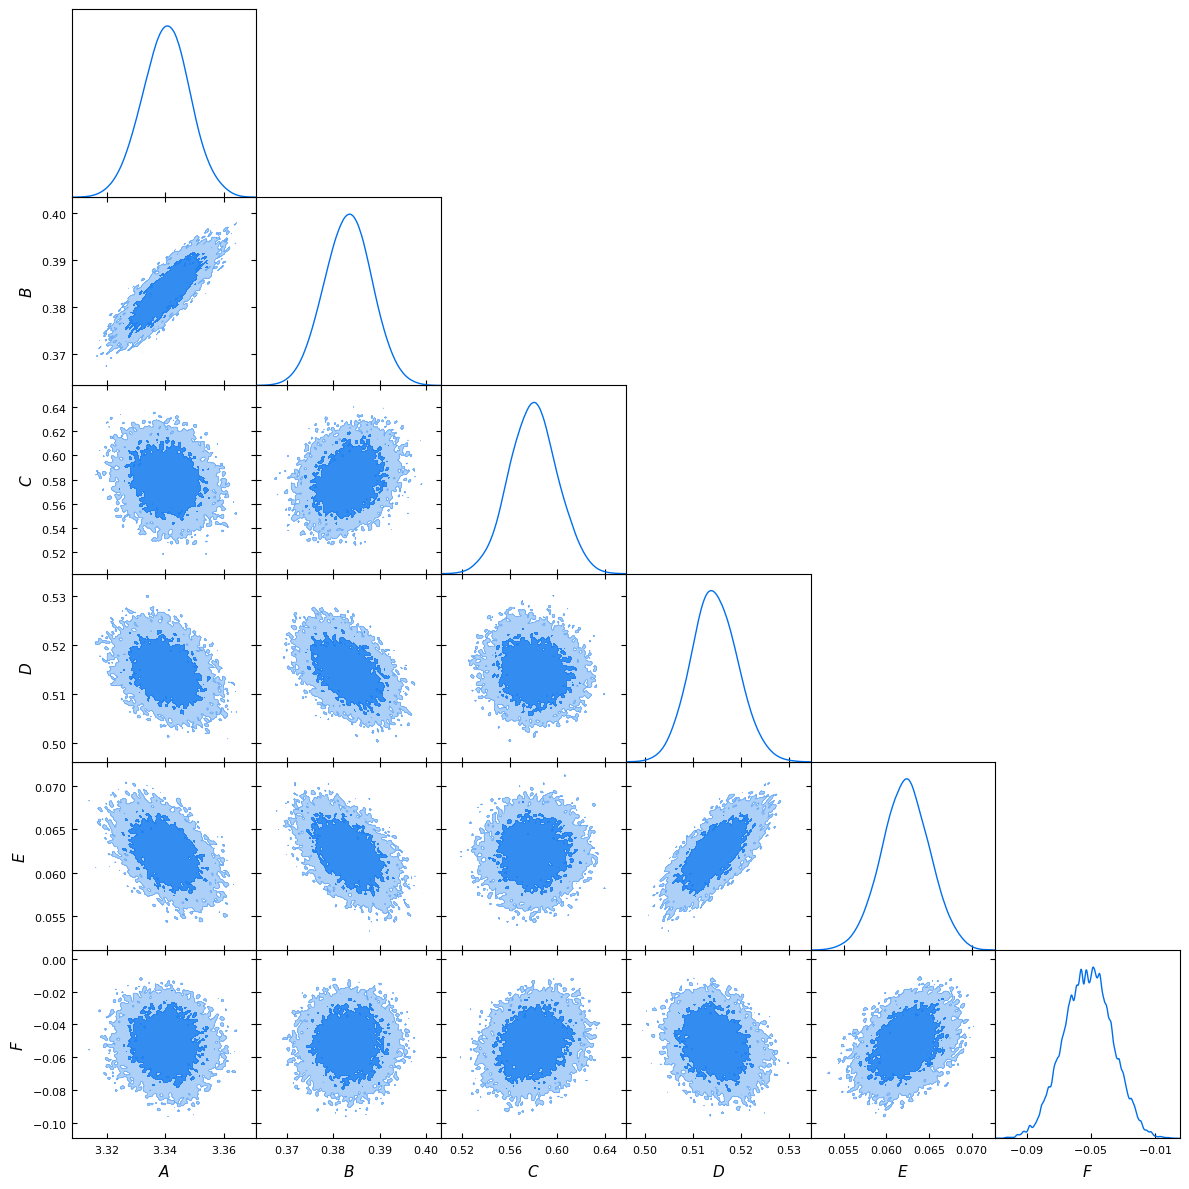

In [21]:
%matplotlib inline

settings = {
    "mult_bias_correction_order": 0,
    "smooth_scale_2D": 3,
    "smooth_scale_1D": 3,
    "boundary_correction_order": 0,
}

g = plots.get_subplot_plotter()
g.triangle_plot(
    [samples],
    filled=True,
    alphas=[0.8, 0.55],
    contour_ls="-",
    contour_lws=1,
    fine_bins=1,
    marker_args={"linewidth": 4}
)
plt.show()
#g.export('output_file.pdf')